## 📅 Day 4: Training Loop Basics

In [ ]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 2),
            nn.ReLU(),
            nn.Linear(2, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [2]:
import torch
import torch.optim as optim

x = torch.randn(100, 2)
y = (x[:, 0] + x[:, 1] > 0).float().unsqueeze(1)

model = MLP()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

# minimal training loop
for epoch in range(10):
    optimizer.zero_grad()
    pred = model(x)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.7663
Epoch 1, Loss: 0.7615
Epoch 2, Loss: 0.7571
Epoch 3, Loss: 0.7529
Epoch 4, Loss: 0.7490
Epoch 5, Loss: 0.7456
Epoch 6, Loss: 0.7427
Epoch 7, Loss: 0.7401
Epoch 8, Loss: 0.7375
Epoch 9, Loss: 0.7351


In [3]:
# 🧠 Homework:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=2000, n_features=16, 
                           n_classes=2, n_informative=10, random_state=42)

In [15]:
y.shape

(2000,)

In [16]:
class oneResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(16, 64, bias=False),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 16)
        )
        self.final = nn.Sequential(
            nn.LayerNorm(16),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        y = self.layers(x) + x
        y = self.final(y)
        return y

In [52]:
model = oneResidualBlock()
# - Implement same training loop with SGD
optimizer = optim.SGD(model.parameters(), lr=0.01)
# - Try MSELoss and compare with BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()
criterion2 = nn.MSELoss()

In [24]:
model(torch.from_numpy(X).float()).shape

torch.Size([2000, 1])

In [28]:
torch.from_numpy(y).unsqueeze(dim=1).shape

torch.Size([2000, 1])

In [29]:
def get_batches(X, y, batch_size):
    n_samples = X.shape[0]
    indices = torch.randperm(n_samples)  # shuffle indices
    for start in range(0, n_samples, batch_size):
        end = start + batch_size
        batch_idx = indices[start:end]
        yield torch.from_numpy(X[batch_idx]).float(), torch.from_numpy(y[batch_idx]).unsqueeze(dim=1).float(), end

In [68]:
def training_loop(X, y, batch_size, model, optimizer, criterion):
    size = X.shape[0]
    model.train()
    for Xb, yb, current_batch in get_batches(X, y, batch_size): 
        # Call optimizer.zero_grad() to reset the gradients of model parameters.
        optimizer.zero_grad()
        prediction = model(Xb)
        loss = criterion(prediction, yb)
        # Backpropagate the prediction loss with a call to loss.backward(). 
        loss.backward()
        # Once we have our gradients, we call optimizer.step() to adjust the parameters by the gradients collected in the backward pass.
        optimizer.step()
        if current_batch % 10 == 0:
            print(f"loss: {loss.item():>7f}  [{current_batch:>5d}/{size:>5d}]")
    return loss.item()

In [36]:
def evaluation_loop(X, y, batch_size, model, criterion):
    model.eval()
    total_loss, total_examples, correct = 0.0, 0, 0
    with torch.no_grad():
        for Xb, yb, _ in get_batches(X, y, batch_size): 
            prediction = model(Xb)
            loss = criterion(prediction, yb)
            bsz = yb.shape[0]
            total_loss += loss.item() * bsz
            probs = torch.sigmoid(prediction)
            preds = (probs >= 0.5).float()
            correct += (preds == yb).sum().item()
            total_examples += bsz
    test_loss = total_loss / total_examples
    correct /= total_examples
    # - Log both loss and accuracy
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [71]:
epochs=50
loss_history = {"train_loss": [], "val_loss": []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_train = training_loop(X_train, y_train, 32, model, optimizer, criterion)
    loss_epoch, accuracy_epoch = evaluation_loop(X_test, y_test, 32, model, criterion)
    loss_history["train_loss"].append(loss_train)
    loss_history["val_loss"].append(loss_epoch)

Epoch 1
-------------------------------
loss: 0.045622  [  160/ 1340]
loss: 0.025517  [  320/ 1340]
loss: 0.060066  [  480/ 1340]
loss: 0.128816  [  640/ 1340]
loss: 0.128997  [  800/ 1340]
loss: 0.315987  [  960/ 1340]
loss: 0.066981  [ 1120/ 1340]
loss: 0.248916  [ 1280/ 1340]
Test Error: 
 Accuracy: 93.5%, Avg loss: 0.200068 

Epoch 2
-------------------------------
loss: 0.119944  [  160/ 1340]
loss: 0.083267  [  320/ 1340]
loss: 0.148067  [  480/ 1340]
loss: 0.178789  [  640/ 1340]
loss: 0.145104  [  800/ 1340]
loss: 0.071999  [  960/ 1340]
loss: 0.085897  [ 1120/ 1340]
loss: 0.107439  [ 1280/ 1340]
Test Error: 
 Accuracy: 93.2%, Avg loss: 0.200803 

Epoch 3
-------------------------------
loss: 0.239657  [  160/ 1340]
loss: 0.184672  [  320/ 1340]
loss: 0.124398  [  480/ 1340]
loss: 0.145338  [  640/ 1340]
loss: 0.082969  [  800/ 1340]
loss: 0.135947  [  960/ 1340]
loss: 0.127849  [ 1120/ 1340]
loss: 0.074044  [ 1280/ 1340]
Test Error: 
 Accuracy: 93.2%, Avg loss: 0.200260 

Epoc

In [54]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    """
    history: dict containing lists per epoch
      e.g. {"train_loss": [...], "val_loss": [...], "train_acc": [...], "val_acc": [...]}
    """

    epochs = range(1, len(history["train_loss"]) + 1)

    # --- Loss plot ---
    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [72]:
# - Explore learning rate effects (0.1, 0.001)
def train_and_plot(lr,epochs):
    model = oneResidualBlock()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    loss_history = {"train_loss": [], "val_loss": []}
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        loss_train = training_loop(X_train, y_train, 32, model, optimizer, criterion)
        loss_epoch, accuracy_epoch = evaluation_loop(X_test, y_test, 32, model, criterion)
        loss_history["train_loss"].append(loss_train)
        loss_history["val_loss"].append(loss_epoch)
    
    # - Plot loss vs epoch
    plot_training_curves(loss_history)
    return loss_history

Epoch 1
-------------------------------
loss: 0.646484  [  160/ 1340]
loss: 0.600392  [  320/ 1340]
loss: 0.532051  [  480/ 1340]
loss: 0.475965  [  640/ 1340]
loss: 0.513879  [  800/ 1340]
loss: 0.498084  [  960/ 1340]
loss: 0.444598  [ 1120/ 1340]
loss: 0.393303  [ 1280/ 1340]
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.419784 

Epoch 2
-------------------------------
loss: 0.426992  [  160/ 1340]
loss: 0.373116  [  320/ 1340]
loss: 0.369242  [  480/ 1340]
loss: 0.352144  [  640/ 1340]
loss: 0.348149  [  800/ 1340]
loss: 0.374494  [  960/ 1340]
loss: 0.378802  [ 1120/ 1340]
loss: 0.214759  [ 1280/ 1340]
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.340877 

Epoch 3
-------------------------------
loss: 0.338852  [  160/ 1340]
loss: 0.158741  [  320/ 1340]
loss: 0.469599  [  480/ 1340]
loss: 0.378963  [  640/ 1340]
loss: 0.292089  [  800/ 1340]
loss: 0.205510  [  960/ 1340]
loss: 0.207234  [ 1120/ 1340]
loss: 0.261392  [ 1280/ 1340]
Test Error: 
 Accuracy: 88.2%, Avg loss: 0.297445 

Epoc

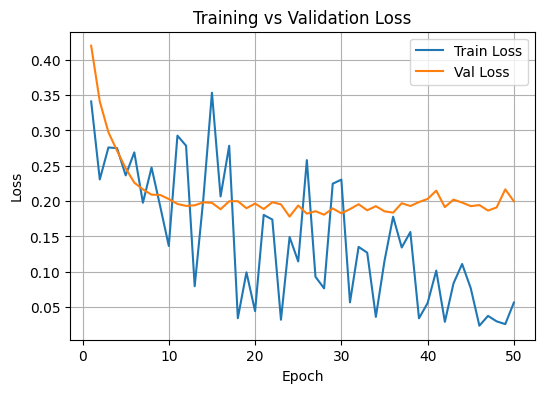

In [79]:
loss_history_1 = train_and_plot(0.1,50)

Epoch 1
-------------------------------
loss: 0.778406  [  160/ 1340]
loss: 0.829792  [  320/ 1340]
loss: 0.824112  [  480/ 1340]
loss: 0.639006  [  640/ 1340]
loss: 0.701633  [  800/ 1340]
loss: 0.660747  [  960/ 1340]
loss: 0.690394  [ 1120/ 1340]
loss: 0.640765  [ 1280/ 1340]
Test Error: 
 Accuracy: 60.2%, Avg loss: 0.662226 

Epoch 2
-------------------------------
loss: 0.676596  [  160/ 1340]
loss: 0.665843  [  320/ 1340]
loss: 0.611983  [  480/ 1340]
loss: 0.620537  [  640/ 1340]
loss: 0.701681  [  800/ 1340]
loss: 0.525065  [  960/ 1340]
loss: 0.582488  [ 1120/ 1340]
loss: 0.681299  [ 1280/ 1340]
Test Error: 
 Accuracy: 68.8%, Avg loss: 0.601598 

Epoch 3
-------------------------------
loss: 0.572733  [  160/ 1340]
loss: 0.589231  [  320/ 1340]
loss: 0.667443  [  480/ 1340]
loss: 0.632634  [  640/ 1340]
loss: 0.595056  [  800/ 1340]
loss: 0.519869  [  960/ 1340]
loss: 0.513911  [ 1120/ 1340]
loss: 0.527948  [ 1280/ 1340]
Test Error: 
 Accuracy: 74.1%, Avg loss: 0.558695 

Epoc

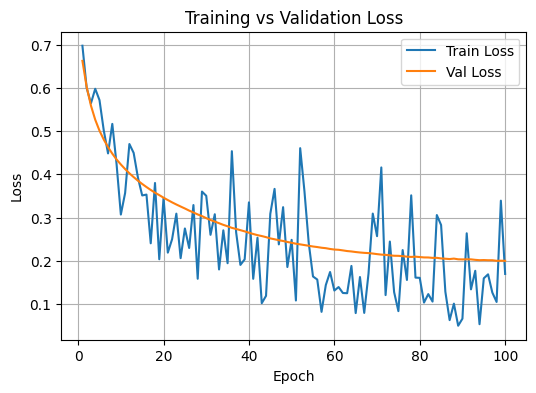

In [80]:
loss_history_2 = train_and_plot(0.01,100)